### Basic neural activity analysis with single camera tracking
#### analyze the firing rate PC1,2,3
#### making the demo videos
#### analyze the spike triggered pull and gaze ditribution

In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import scipy.io
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import string
import warnings
import pickle
import json

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [8]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [9]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_demo import tracking_video_singlecam_wholebody_withNeuron_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo


### function - interval between all behavioral events

In [10]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [11]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation
from ana_functions.plot_spike_triggered_singlecam_bhvevent import plot_spike_triggered_singlecam_bhvevent
from ana_functions.plot_bhv_events_aligned_FR import plot_bhv_events_aligned_FR

### function - PCA projection

In [12]:
from ana_functions.PCA_around_bhv_events import PCA_around_bhv_events

In [13]:
from ana_functions.PCA_around_bhv_events_video import PCA_around_bhv_events_video

In [14]:
from ana_functions.confidence_ellipse import confidence_ellipse

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [15]:
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag_withNeuron import graph_to_matrix
from ana_functions.train_DBN_multiLag_withNeuron import get_weighted_dags
from ana_functions.train_DBN_multiLag_withNeuron import get_significant_edges
from ana_functions.train_DBN_multiLag_withNeuron import threshold_edges
from ana_functions.train_DBN_multiLag_withNeuron import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [16]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC  = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson ginger
if 0:
    if do_DLPFC:
        neural_record_conditions = [
                                     # # '20231204_Dodson_withGinger_SR', 
                                     # '20231204_Dodson_withGinger_MC',
                                    # '20240610_Dodson_MC',
                                    '20240531_Dodson_MC_and_SR',
                                   ]
        task_conditions = [
                            'MC_and_SR',
                          ]
        dates_list = [
                      # # "20231204_SR","20231204_MC",
                      # '20240610_MC',
                      '20240531',
                     ]
        session_start_times = [ 
                                # # 0.00,  107.50, 
                                # 0.00, 
                                0.00,
                              ] # in second
        kilosortvers = [ 
                         # # 2, 2,
                         # 4,
                         4,
                       ]
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     '20231107_Dodson_withGinger_MC',
                                     '20231122_Dodson_withGinger_MC',
                                     '20231129_Dodson_withGinger_MC',
                                     '20231101_Dodson_withGinger_SR',
                                     '20231107_Dodson_withGinger_SR',
                                     '20231122_Dodson_withGinger_SR',
                                     '20231129_Dodson_withGinger_SR',
                                   ]
        task_conditions = [
                            'MC',
                            'MC',
                            'MC',
                            'MC',
                            'SR',
                            'SR',
                            'SR',
                            'SR',
                          ]
        dates_list = [
                      "20231101_MC",
                      "20231107_MC",
                      "20231122_MC",
                      "20231129_MC",
                      "20231101_SR",
                      "20231107_SR",
                      "20231122_SR",
                      "20231129_SR",
            
                     ]
        session_start_times = [ 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                              ] # in second
        kilosortvers = [ 
                         2, 2, 4, 4,
                         2, 2, 4, 4,
                       ]
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['ginger']

    animal1_filename = "Dodson"
    animal2_filename = "Ginger"

    
# dannon kanga
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240508_Kanga_SR',
                                     '20240509_Kanga_MC',
                                     '20240513_Kanga_MC',
                                     '20240514_Kanga_SR',
                                     '20240523_Kanga_MC',
                                     '20240524_Kanga_SR',
                                     '20240606_Kanga_MC',
                                     '20240613_Kanga_MC_DannonAuto',
                                     '20240614_Kanga_MC_DannonAuto',
                                     '20240617_Kanga_MC_DannonAuto',
                                     '20240618_Kanga_MC_KangaAuto',
                                     '20240619_Kanga_MC_KangaAuto',
                                     '20240620_Kanga_MC_KangaAuto',
                                     '20240621_1_Kanga_NoVis',
                                     '20240624_Kanga_NoVis',
                                     '20240626_Kanga_NoVis',
                                   ]
        dates_list = [
                      "20240508",
                      "20240509",
                      "20240513",
                      "20240514",
                      "20240523",
                      "20240524",
                      "20240606",
                      "20240613",
                      "20240614",
                      "20240617",
                      "20240618",
                      "20240619",
                      "20240620",
                      "20240621_1",
                      "20240624",
                      "20240626",
                     ]
        task_conditions = [
                             'SR',
                             'MC',
                             'MC',
                             'SR',
                             'MC',
                             'SR',
                             'MC',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'NV',
                             'NV',
                             'NV',    
                          ]
        session_start_times = [ 
                                 0.00,
                                 36.0,
                                 69.5,
                                 0.00,
                                 62.0,
                                 0.00,
                                 89.0,
                                 0.00,
                                 0.00,
                                 0.00,
                                 165.8,
                                 96.0, 
                                 0.00,
                                 0.00,
                                 0.00,
                                 48.0,
                              ] # in second
        kilosortvers = [
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                        ]
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        task_conditions = [
                           
                          ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [ 

                       ]
    
    animal1_fixedorder = ['dannon']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Dannon"
    animal2_filename = "Kanga"
    

    
# a test case
if 0:
    neural_record_conditions = ['20240508_Kanga_SR']
    dates_list = ["20240508"]
    task_conditions = ['SR']
    session_start_times = [0.0] # in second
    kilosortvers = [4]
    animal1_fixedorder = ['dannon']
    animal2_fixedorder = ['kanga']
    animal1_filename = "Dannon"
    animal2_filename = "Kanga"
if 0:
    neural_record_conditions = ['20231101_Dodson_withGinger_MC']
    dates_list = ["20231101_MC"]
    task_conditions = ['MC']
    session_start_times = [0.0] # in second
    kilosortvers = [2]
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['ginger']
    animal1_filename = "Dodson"
    animal2_filename = "Ginger"
    
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])

spike_trig_events_all_dates = dict.fromkeys(dates_list, [])

bhvevents_aligned_FR_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/Marmoset_neural_recording/'

    

In [17]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/spike_trig_events_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        spike_trig_events_all_dates = pickle.load(f) 
        
    with open(data_saved_subfolder+'/bhvevents_aligned_FR_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhvevents_aligned_FR_all_dates = pickle.load(f) 
        
    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]
        
        kilosortver = kilosortvers[idate]


        # folder and file path
        camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        # 
        try: 
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"                
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
        pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
  

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second and align to the start of the session
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            
        # define successful pulls and failed pulls
        trialnum_succ = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']>0])
        bhv_data_succ = bhv_data[np.isin(bhv_data['trial_number'],trialnum_succ)]
        #
        time_point_pull1_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==1]
        time_point_pull2_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==2]
        time_point_pull1_succ = np.round(time_point_pull1_succ,1)
        time_point_pull2_succ = np.round(time_point_pull2_succ,1)
        #
        trialnum_fail = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']==0])
        bhv_data_fail = bhv_data[np.isin(bhv_data['trial_number'],trialnum_fail)]
        #
        time_point_pull1_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==1]
        time_point_pull2_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==2]
        time_point_pull1_fail = np.round(time_point_pull1_fail,1)
        time_point_pull2_fail = np.round(time_point_pull2_fail,1)
        # 
        time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                      "pull2_succ":time_point_pull2_succ,
                                      "pull1_fail":time_point_pull1_fail,
                                      "pull2_fail":time_point_pull2_fail,
                                    }
            
                
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
        owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
        mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if 1:
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
        
        
        
        # session starting time compared with the neural recording
        session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
        neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
        neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    
        # load channel maps
        channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32.mat'
        # channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32_kilosort4_new.mat'
        channel_map_data = scipy.io.loadmat(channel_map_file)
            
        # # load spike sorting results
        if 1:
            print('load spike data for '+neural_record_condition)
            if kilosortver == 2:
                spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            elif kilosortver == 4:
                spike_time_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            # 
            # align the FR recording time stamps
            spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
            # down-sample the spike recording resolution to 30Hz
            spike_time_data = spike_time_data/fs_spikes*fps
            spike_time_data = np.round(spike_time_data)
            #
            if kilosortver == 2:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            elif kilosortver == 4:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            #
            if kilosortver == 2:
                channel_maps_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            elif kilosortver == 4:
                channel_maps_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            #
            if kilosortver == 2:
                channel_pos_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            elif kilosortver == 4:
                channel_pos_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            #
            if kilosortver == 2:
                clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            elif kilosortver == 4:
                clusters_info_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            #
            # only get the spikes that are manually checked
            try:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['cluster_id'].values
            except:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['id'].values
            #
            clusters_info_data = clusters_info_data[~pd.isnull(clusters_info_data.group)]
            #
            spike_time_data = spike_time_data[np.isin(spike_clusters_data,good_clusters)]
            spike_channels_data = spike_channels_data[np.isin(spike_clusters_data,good_clusters)]
            spike_clusters_data = spike_clusters_data[np.isin(spike_clusters_data,good_clusters)]
            
            #
            nclusters = np.shape(clusters_info_data)[0]
            #
            for icluster in np.arange(0,nclusters,1):
                try:
                    cluster_id = clusters_info_data['id'].iloc[icluster]
                except:
                    cluster_id = clusters_info_data['cluster_id'].iloc[icluster]
                spike_channels_data[np.isin(spike_clusters_data,cluster_id)] = clusters_info_data['ch'].iloc[icluster]   
            # 
            # get the channel to depth information, change 2 shanks to 1 shank 
            try:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1]*2,channel_pos_data[channel_pos_data[:,0]==1,1]*2+1])
                # channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
            except:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
                channel_to_depth[1] = channel_to_depth[1]/30-64 # make the y axis consistent
            #
           
            
            # calculate the firing rate
            # FR_kernel = 0.20 # in the unit of second
            FR_kernel = 1/30 # in the unit of second # 1/30 same resolution as the video recording
            # FR_kernel is sent to to be this if want to explore it's relationship with continuous trackng data
            
            totalsess_time_forFR = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30)  # to match the total time of the video recording
            # _,FR_timepoint_allclusters,FR_allclusters,FR_zscore_allclusters = spike_analysis_FR_calculation(fps, FR_kernel, totalsess_time_forFR,
            #                                                                                                spike_clusters_data, spike_time_data)
            _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps,FR_kernel,totalsess_time_forFR,
                                                                                         spike_channels_data, spike_time_data)
            # behavioral events aligned firing rate for each unit
            if 1: 
                print('plot event aligned firing rate')
                #
                savefig = 1
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filename+"_"+animal2_filename+"/"+date_tgt
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                #
                aligntwins = 4 # 5 second
                gaze_thresold = 0.2 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
                #
                bhvevents_aligned_FR_average_all = plot_bhv_events_aligned_FR(date_tgt,savefig,save_path, animal1, animal2,time_point_pull1,time_point_pull2,time_point_pulls_succfail,
                                           oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,
                                           aligntwins,fps,FR_timepoint_allch,FR_zscore_allch)
                
                bhvevents_aligned_FR_all_dates[date_tgt] = bhvevents_aligned_FR_average_all
            
            #
            # Run PCA analysis
            FR_zscore_allch_np_merged = np.array(pd.DataFrame(FR_zscore_allch).T)
            FR_zscore_allch_np_merged = FR_zscore_allch_np_merged[~np.isnan(np.sum(FR_zscore_allch_np_merged,axis=1)),:]
            # # run PCA on the entire session
            pca = PCA(n_components=3)
            FR_zscore_allch_PCs = pca.fit_transform(FR_zscore_allch_np_merged.T)
            #
            # # run PCA around the -PCAtwins to PCAtwins for each behavioral events
            PCAtwins = 4 # 5 second
            gaze_thresold = 0.5 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
            savefigs = 1 
            if 1:
                PCA_around_bhv_events(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull1,time_point_pull2,time_point_pulls_succfail, 
                              oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                              savefigs,data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
            if 0:
                if np.isin(animal1, ['dodson','dannon']):
                    PCA_around_bhv_events_video(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull1,time_point_pull2,time_point_pulls_succfail, 
                                      oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                                      data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
                elif np.isin(animal2, ['dodson','dannon']):
                    time_point_pulls_succfail_rev = time_point_pulls_succfail.copy()
                    time_point_pulls_succfail_rev['pull1_succ'] = time_point_pulls_succfail['pull2_succ']
                    time_point_pulls_succfail_rev['pull1_fail'] = time_point_pulls_succfail['pull2_fail']
                    time_point_pulls_succfail_rev['pull2_succ'] = time_point_pulls_succfail['pull1_succ']
                    time_point_pulls_succfail_rev['pull2_fail'] = time_point_pulls_succfail['pull1_fail']
                    PCA_around_bhv_events_video(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull2,time_point_pull1,time_point_pulls_succfail_rev, 
                                      oneway_gaze2,oneway_gaze1,mutual_gaze2,mutual_gaze1,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                                      data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
            
            
            
            # do the spike triggered average of different bhv variables, for the single camera tracking, look at the pulling and social gaze actions
            # the goal is to get a sense for glm
            if 1: 
                print('plot spike triggered bhv variables')

                savefig = 1
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filename+"_"+animal2_filename+"/"+date_tgt
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                #
                do_shuffle = 0
                #
                min_length = np.shape(look_at_other_or_not_merge['dodson'])[0] # frame numbers of the video recording
                #
                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                gaze_thresold = 0.2
                #
                spike_trig_average_all =  plot_spike_triggered_singlecam_bhvevent(date_tgt,savefig,save_path, animal1, animal2, session_start_time,min_length, trig_twins,
                                                                              time_point_pull1, time_point_pull2, time_point_pulls_succfail,
                                                                              oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,animalnames_videotrack,
                                                                              spike_clusters_data, spike_time_data,spike_channels_data,do_shuffle)

                spike_trig_events_all_dates[date_tgt] = spike_trig_average_all

            
        # load filtered lfp
        if 0:
            print('load LFP data for '+neural_record_condition)
            lfp_filt_filename = neural_data_folder+neural_record_condition+'/lfp_filt_subsample.txt' # already downsample to 30Hz
            lfp_filt_data_df = genfromtxt(lfp_filt_filename, delimiter=',')
            # aligned to the session start
            lfp_filt_sess_aligned=lfp_filt_data_df[:,int(-neural_start_time_session_start_offset*30):]
            # normalize the activity to 0 - 1
            lfp_filt_sess_aligned = (lfp_filt_sess_aligned-np.min(lfp_filt_sess_aligned))/(np.max(lfp_filt_sess_aligned)-np.min(lfp_filt_sess_aligned))


            
        
        # plot the tracking demo video
        if 0: 
            if 0:
                # all the bhv traces in the same panel
                tracking_video_singlecam_wholebody_withNeuron_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                  lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                  animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                  animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                                  video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body,
                                                  spike_time_data,lfp_filt_sess_aligned,spike_channels_data,channel_to_depth)
            if 1:
                # all the bhv traces are in separate panels
                tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                 lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                 animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                 animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                                 video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body,
                                                 spike_time_data,lfp_filt_sess_aligned,spike_channels_data,channel_to_depth)
        
        
        

    # save data
    if 1:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
            
        with open(data_saved_subfolder+'/spike_trig_events_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(spike_trig_events_all_dates, f)  
    
        with open(data_saved_subfolder+'/bhvevents_aligned_FR_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhvevents_aligned_FR_all_dates, f)  
    
    
    
    

all data from all dates are loaded


### plot 
#### plot the PCs

In [24]:
if 0:
    fig, axs = plt.subplots(12,1)
    fig.set_figheight(20*1)
    fig.set_figwidth(5*3)

    x_lims = [0,totalsess_time_forFR]
    PC1min = np.min(FR_zscore_allch_PCs[:,0])
    PC1max = np.max(FR_zscore_allch_PCs[:,0])
    PC2min = np.min(FR_zscore_allch_PCs[:,1])
    PC2max = np.max(FR_zscore_allch_PCs[:,1])
    PC3min = np.min(FR_zscore_allch_PCs[:,2])
    PC3max = np.max(FR_zscore_allch_PCs[:,2])

    for iplotype in np.arange(0,4,1):

        if iplotype == 0:
            eventplot  = np.array(time_point_pull1)
            eventplotname = 'animal1_pull'
        elif iplotype == 1:
            eventplot  = np.array(time_point_pull2)
            eventplotname = 'animal2_pull'
        elif iplotype == 2:
            eventplot  = np.hstack([oneway_gaze1,mutual_gaze1])
            eventplotname = 'animal1_gaze'
        elif iplotype == 3:
            eventplot  = np.hstack([oneway_gaze2,mutual_gaze2])
            eventplotname = 'animal2_gaze'

        # plot 1
        nevents = np.shape(eventplot)[0]
        for ievent in np.arange(0,nevents,1):
            axs[0+3*iplotype].plot([eventplot[ievent],eventplot[ievent]],[PC1min,PC1max],'k-')
        axs[0+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[0+3*iplotype].set_ylim(PC1min,PC1max)
        #
        axs[0+3*iplotype].plot(FR_timepoint_allch,FR_zscore_allch_PCs[:,0])
        axs[0+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[0+3*iplotype].set_ylabel('PC1\n'+eventplotname)

        # plot 2
        nevents = np.shape(eventplot)[0]
        for ievent in np.arange(0,nevents,1):
            axs[1+3*iplotype].plot([eventplot[ievent],eventplot[ievent]],[PC2min,PC2max],'k-')
        axs[1+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[1+3*iplotype].set_ylim(PC2min,PC2max)
        #
        axs[1+3*iplotype].plot(FR_timepoint_allch,FR_zscore_allch_PCs[:,1])
        axs[1+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[1+3*iplotype].set_ylabel('PC2\n'+eventplotname)

        # plot 3
        nevents = np.shape(eventplot)[0]
        for ievent in np.arange(0,nevents,1):
            axs[2+3*iplotype].plot([eventplot[ievent],eventplot[ievent]],[PC3min,PC3max],'k-')
        axs[2+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[2+3*iplotype].set_ylim(PC3min,PC3max)
        #
        axs[2+3*iplotype].plot(FR_timepoint_allch,FR_zscore_allch_PCs[:,2])
        axs[2+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[2+3*iplotype].set_ylabel('PC3\n'+eventplotname)


#### analyze the spike triggered behavioral variables across all dates
#### plot the tsne or PCA clusters

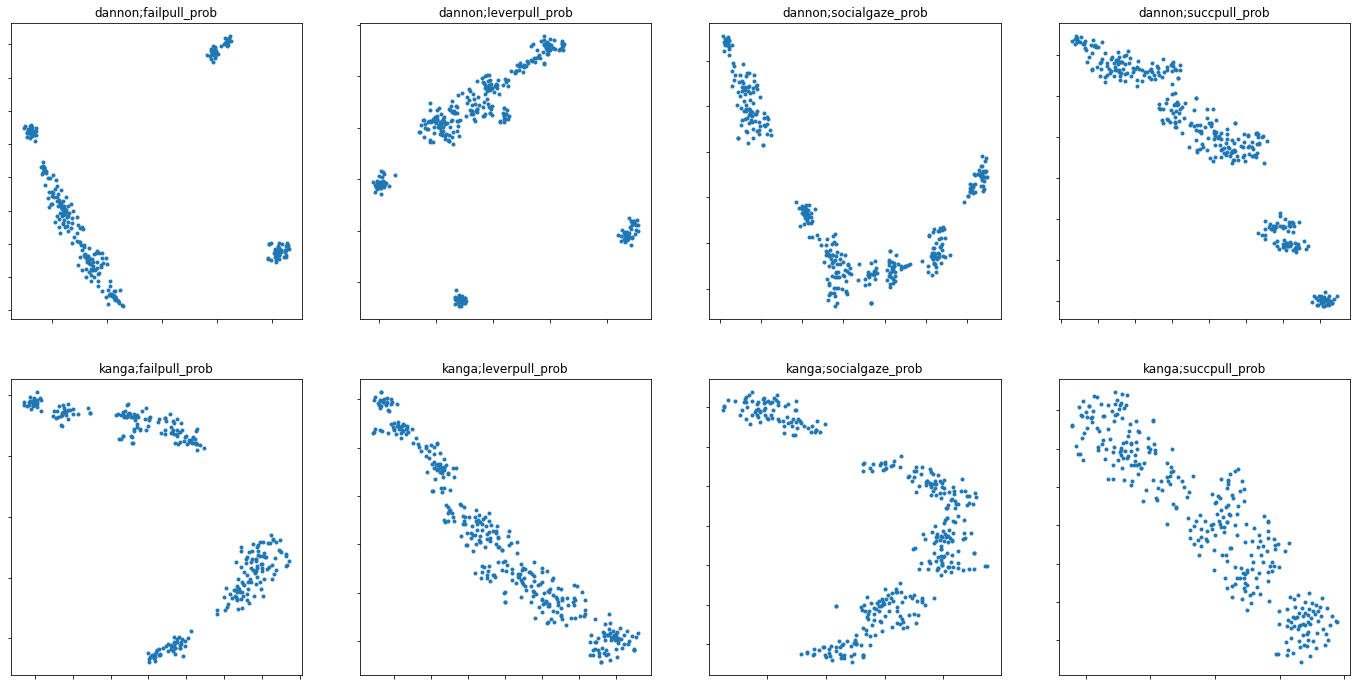

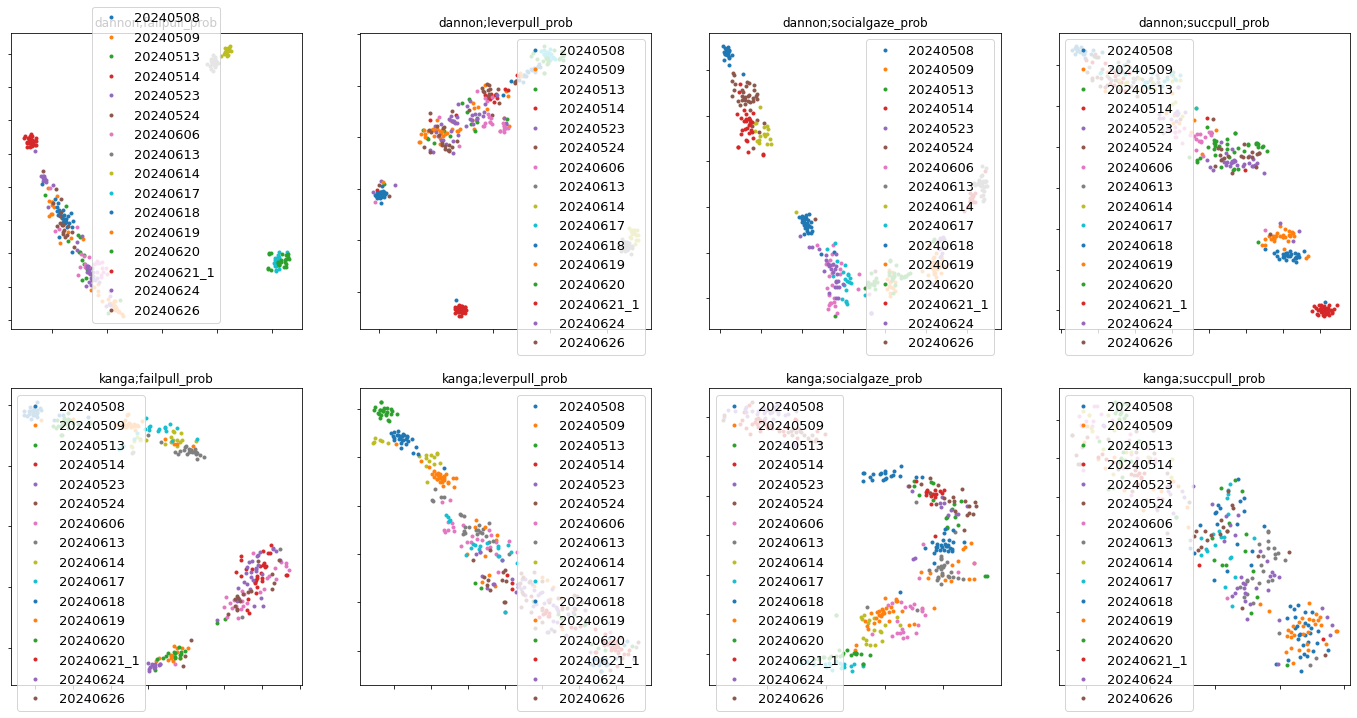

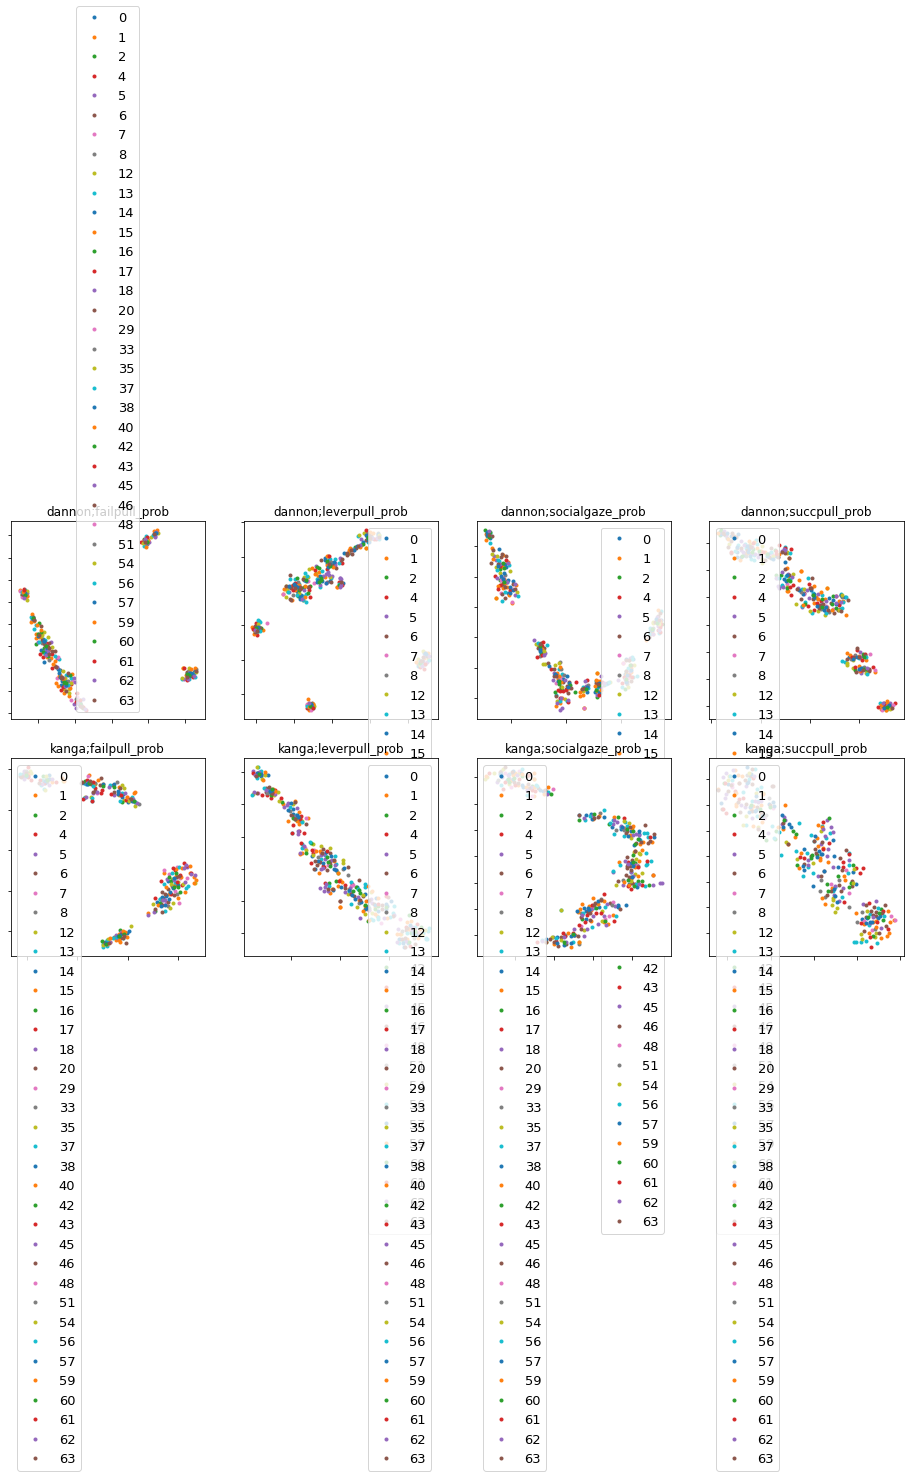

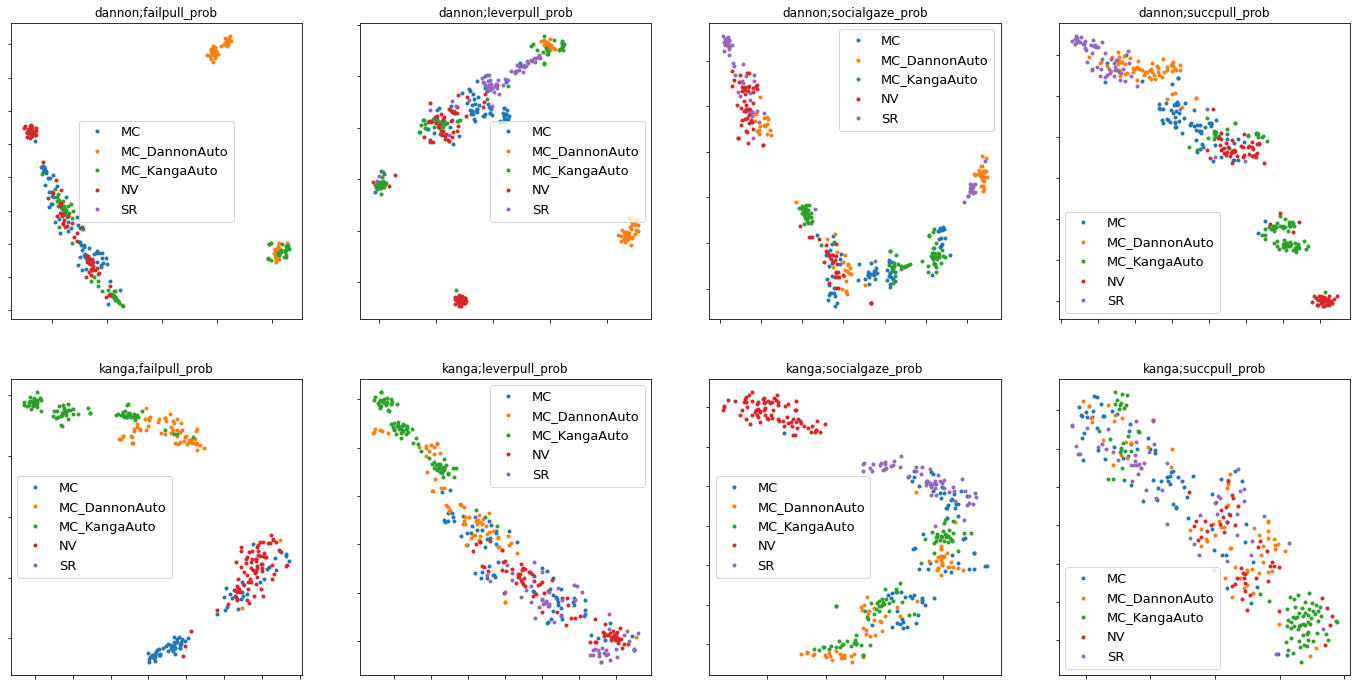

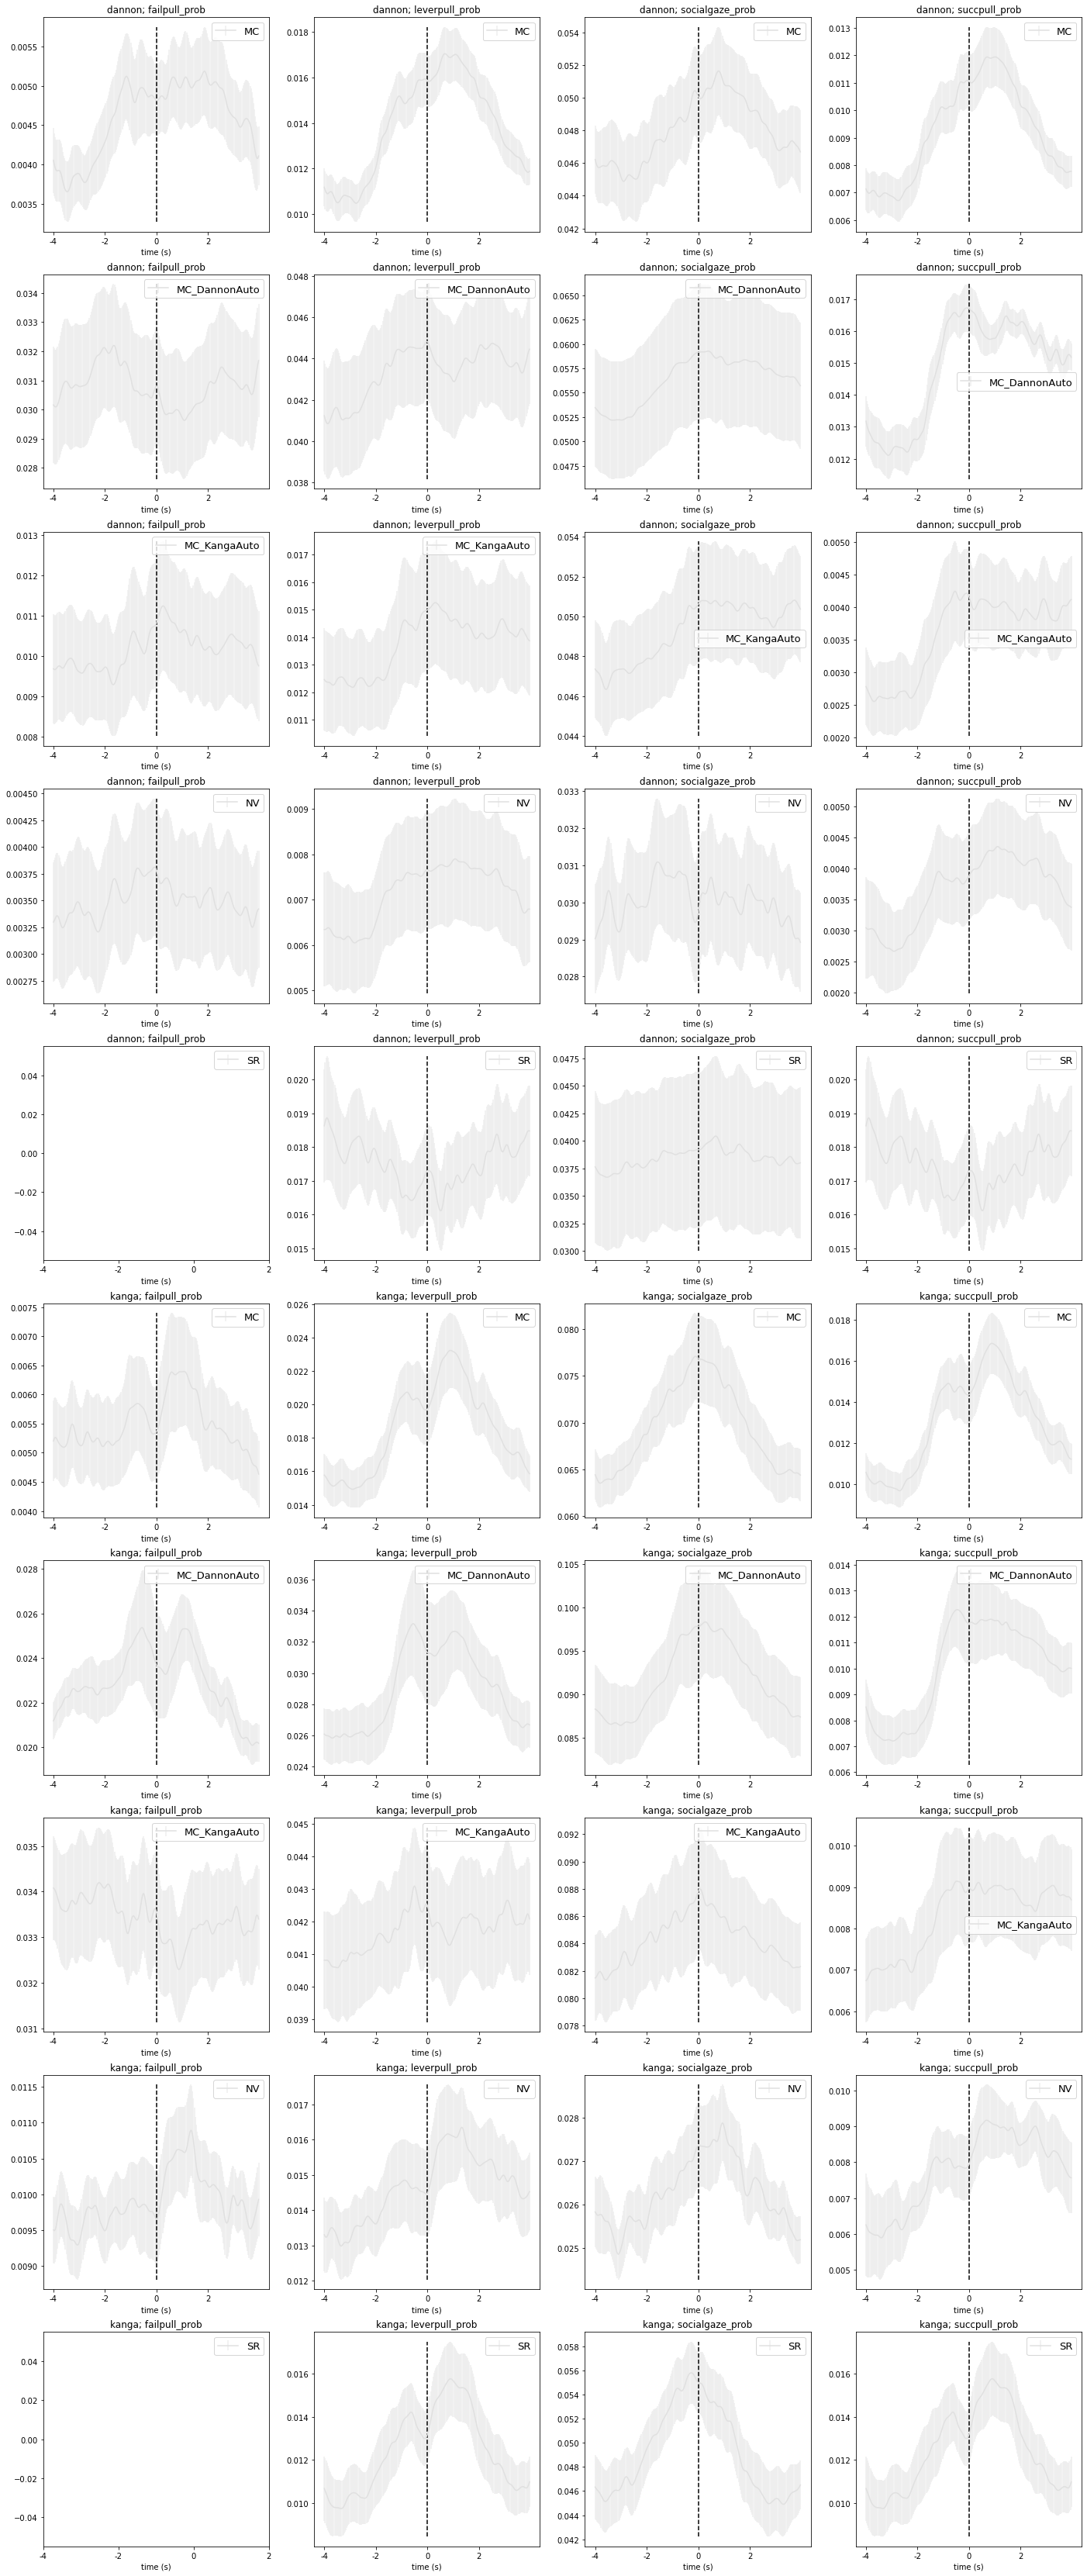

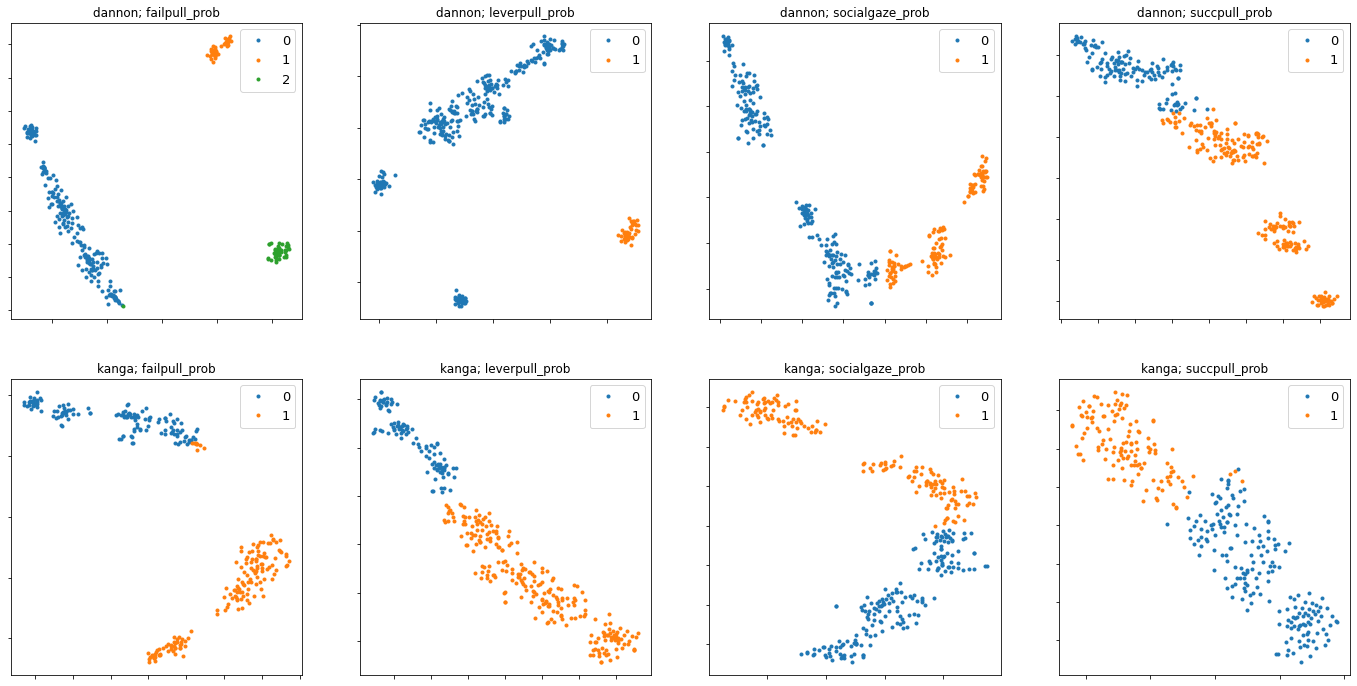

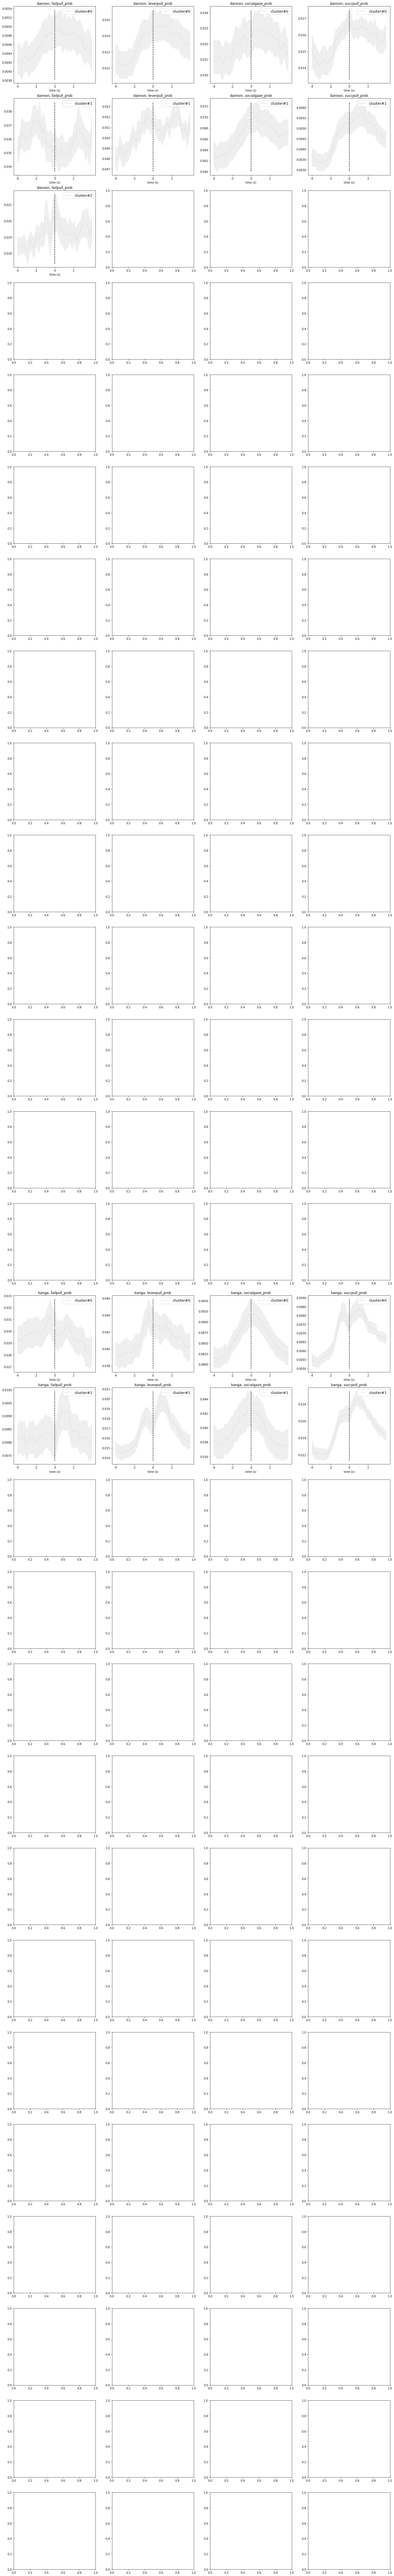

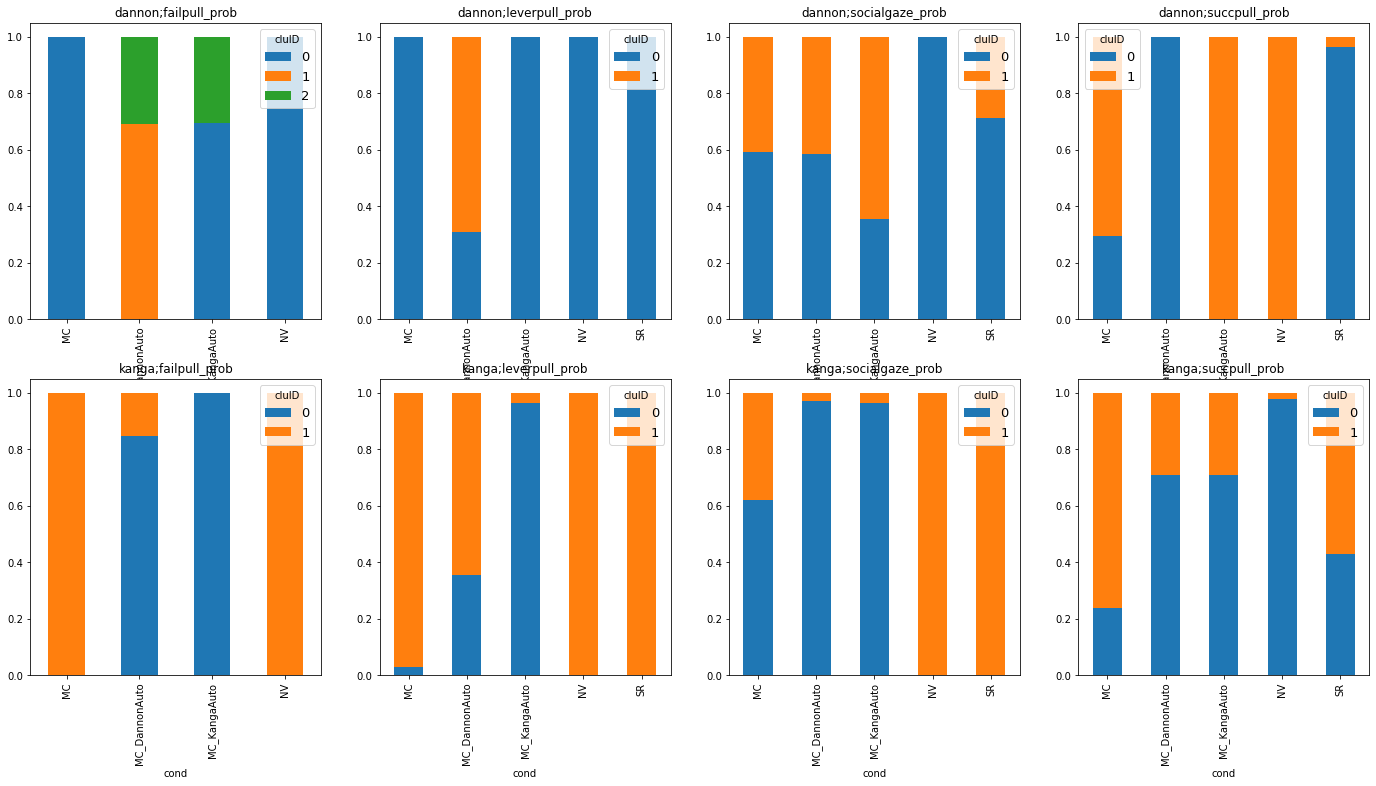

In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

doPCA = 0
doTSNE = 1

spike_trig_events_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                       'channelID','st_average'])

# reorganize to a dataframes
for idate in np.arange(0,ndates,1):
    date_tgt = dates_list[idate]
    task_condition = task_conditions[idate]
    
    act_animals = list(spike_trig_events_all_dates[date_tgt].keys())
    
    for iact_animal in act_animals:
        
        bhv_types = list(spike_trig_events_all_dates[date_tgt][iact_animal].keys())
        
        for ibhv_type in bhv_types:
            
            clusterIDs = list(spike_trig_events_all_dates[date_tgt][iact_animal][ibhv_type].keys())
    
            for iclusterID in clusterIDs:
            
                ichannelID = spike_trig_events_all_dates[date_tgt][iact_animal][ibhv_type][iclusterID]['ch']
                ist_average = spike_trig_events_all_dates[date_tgt][iact_animal][ibhv_type][iclusterID]['st_average']

                spike_trig_events_all_dates_df = spike_trig_events_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal': iact_animal, 
                                                                                        'bhv_name': ibhv_type,
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'st_average':ist_average,
                                                                                       }, ignore_index=True)
if 0:
    # normalize st_average for each unit
    nspikeunits = np.shape(spike_trig_events_all_dates_df)[0]
    for ispikeunit in np.arange(0,nspikeunits,1):
        stevent = spike_trig_events_all_dates_df['st_average'][ispikeunit]
        stevent_norm = (stevent-np.nanmin(stevent))/(np.nanmax(stevent)-np.nanmin(stevent))
        spike_trig_events_all_dates_df['st_average'][ispikeunit] = stevent_norm            
        
# only focus on the certain act animal and certain bhv_name
# act_animals_all = ['kanga']
# bhv_names_all = ['leverpull_prob']
act_animals_all = np.unique(spike_trig_events_all_dates_df['act_animal'])
bhv_names_all = np.unique(spike_trig_events_all_dates_df['bhv_name'])
#
nact_animals = np.shape(act_animals_all)[0]
nbhv_names = np.shape(bhv_names_all)[0]

# set for plot
# plot all units
fig1, axs1 = plt.subplots(nact_animals,nbhv_names)
fig1.set_figheight(6*nact_animals)
fig1.set_figwidth(6*nbhv_names)

# plot all units but separate different days
fig2, axs2 = plt.subplots(nact_animals,nbhv_names)
fig2.set_figheight(6*nact_animals)
fig2.set_figwidth(6*nbhv_names)

# plot all units but seprate different channels
fig3, axs3 = plt.subplots(nact_animals,nbhv_names)
fig3.set_figheight(4*nact_animals)
fig3.set_figwidth(4*nbhv_names)

# plot all units but separate different conditions
fig4, axs4 = plt.subplots(nact_animals,nbhv_names)
fig4.set_figheight(6*nact_animals)
fig4.set_figwidth(6*nbhv_names)

# spike triggered average for different task conditions
# # to be save, prepare for five conditions
fig6, axs6 = plt.subplots(nact_animals*5,nbhv_names)
fig6.set_figheight(6*nact_animals*5)
fig6.set_figwidth(6*nbhv_names)
# fig6, axs6 = plt.subplots(nact_animals,nbhv_names)
# fig6.set_figheight(6*nact_animals)
# fig6.set_figwidth(6*nbhv_names)

# plot all units but separate different k-mean cluster
fig5, axs5 = plt.subplots(nact_animals,nbhv_names)
fig5.set_figheight(6*nact_animals)
fig5.set_figwidth(6*nbhv_names)

# spike triggered average for different k-mean cluster
# to be save, prepare for 14 clusters
fig7, axs7 = plt.subplots(nact_animals*14,nbhv_names)
fig7.set_figheight(6*nact_animals*14)
fig7.set_figwidth(6*nbhv_names)

# stacked bar plot to show the cluster distribution of each conditions
fig8, axs8 = plt.subplots(nact_animals,nbhv_names)
fig8.set_figheight(6*nact_animals)
fig8.set_figwidth(6*nbhv_names)

#
for ianimal in np.arange(0,nact_animals,1):
    
    act_animal = act_animals_all[ianimal]
    
    for ibhvname in np.arange(0,nbhv_names,1):
        
        bhv_name = bhv_names_all[ibhvname]
        
        ind = (spike_trig_events_all_dates_df['act_animal']==act_animal)&(spike_trig_events_all_dates_df['bhv_name']==bhv_name)
        
        spike_trig_events_tgt = np.vstack(list(spike_trig_events_all_dates_df[ind]['st_average']))
        
        ind_nan = np.isnan(np.sum(spike_trig_events_tgt,axis=1)) # exist because of failed pull in SR
        spike_trig_events_tgt = spike_trig_events_tgt[~ind_nan,:]
        
        # k means clustering
        # run clustering on the 15 or 2 dimension PC space (for doPCA), or the whole dataset or 2 dimension (for doTSNE)
        pca = PCA(n_components=2)
        spike_trig_events_pca = pca.fit_transform(spike_trig_events_tgt)
        tsne = TSNE(n_components=2, random_state=0)
        spike_trig_events_tsne = tsne.fit_transform(spike_trig_events_tgt)
        #
        range_n_clusters = np.arange(2,15,1)
        silhouette_avg_all = np.ones(np.shape(range_n_clusters))*np.nan
        nkmeancls = np.shape(range_n_clusters)[0]
        #
        for ikmeancl in np.arange(0,nkmeancls,1):
            n_clusters = range_n_clusters[ikmeancl]
            #
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            # cluster_labels = clusterer.fit_predict(spike_trig_events_tgt)
            if doPCA:
                cluster_labels = clusterer.fit_predict(spike_trig_events_pca)
            if doTSNE:
                cluster_labels = clusterer.fit_predict(spike_trig_events_tgt)
                # cluster_labels = clusterer.fit_predict(spike_trig_events_tsne)
            #
            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            # silhouette_avg = silhouette_score(spike_trig_events_tgt, cluster_labels)
            if doPCA:
                silhouette_avg = silhouette_score(spike_trig_events_pca, cluster_labels)
            if doTSNE:
                silhouette_avg = silhouette_score(spike_trig_events_tgt, cluster_labels)
                # silhouette_avg = silhouette_score(spike_trig_events_tsne, cluster_labels)
            #
            silhouette_avg_all[ikmeancl] = silhouette_avg
        #
        best_k_num = range_n_clusters[silhouette_avg_all==np.nanmax(silhouette_avg_all)][0]
        #
        clusterer = KMeans(n_clusters=best_k_num, random_state=0)
        # kmean_cluster_labels = clusterer.fit_predict(spike_trig_events_tgt)
        if doPCA:
            kmean_cluster_labels = clusterer.fit_predict(spike_trig_events_pca)
        if doTSNE:
            kmean_cluster_labels = clusterer.fit_predict(spike_trig_events_tgt)
            # kmean_cluster_labels = clusterer.fit_predict(spike_trig_events_tsne)
    
    
        # run PCA and TSNE     
        pca = PCA(n_components=2)
        tsne = TSNE(n_components=2, random_state=0)
        #
        spike_trig_events_pca = pca.fit_transform(spike_trig_events_tgt)
        spike_trig_events_tsne = tsne.fit_transform(spike_trig_events_tgt)
        
        # plot all units
        # plot the tsne
        if doTSNE:
            axs1[ianimal,ibhvname].plot(spike_trig_events_tsne[:,0],spike_trig_events_tsne[:,1],'.')
        # plot the pca
        if doPCA:
            axs1[ianimal,ibhvname].plot(spike_trig_events_pca[:,0],spike_trig_events_pca[:,1],'.')
        
        axs1[ianimal,ibhvname].set_xticklabels([])
        axs1[ianimal,ibhvname].set_yticklabels([])
        axs1[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
        
        
        # plot all units, but seprate different dates
        dates_forplot = np.unique(spike_trig_events_all_dates_df[ind]['dates'])
        for idate_forplot in dates_forplot:
            ind_idate = list(spike_trig_events_all_dates_df[ind]['dates']==idate_forplot)
            ind_idate = list(np.array(ind_idate)[~ind_nan])
            #
            # plot the tsne
            if doTSNE:
                axs2[ianimal,ibhvname].plot(spike_trig_events_tsne[ind_idate,0],spike_trig_events_tsne[ind_idate,1],
                                        '.',label=idate_forplot)
            # plot the pca
            if doPCA:
                axs2[ianimal,ibhvname].plot(spike_trig_events_pca[ind_idate,0],spike_trig_events_pca[ind_idate,1],
                                        '.',label=idate_forplot)
            #
        axs2[ianimal,ibhvname].set_xticklabels([])
        axs2[ianimal,ibhvname].set_yticklabels([])
        axs2[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
        axs2[ianimal,ibhvname].legend()
        
        
        # plot all units, but seprate different channels
        chs_forplot = np.unique(spike_trig_events_all_dates_df[ind]['channelID'])
        for ich_forplot in chs_forplot:
            ind_ich = list(spike_trig_events_all_dates_df[ind]['channelID']==ich_forplot)
            ind_ich = list(np.array(ind_ich)[~ind_nan])
            #
            # plot the tsne
            if doTSNE:
                axs3[ianimal,ibhvname].plot(spike_trig_events_tsne[ind_ich,0],spike_trig_events_tsne[ind_ich,1],
                                        '.',label=str(ich_forplot))
            # plot the pca
            if doPCA:
                axs3[ianimal,ibhvname].plot(spike_trig_events_pca[ind_ich,0],spike_trig_events_pca[ind_ich,1],
                                        '.',label=str(ich_forplot))
            #
        axs3[ianimal,ibhvname].set_xticklabels([])
        axs3[ianimal,ibhvname].set_yticklabels([])
        axs3[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
        axs3[ianimal,ibhvname].legend()
        
        
        # plot all units, but seprate different task conditions
        cons_forplot = np.unique(spike_trig_events_all_dates_df[ind]['condition'])
        for icon_forplot in cons_forplot:
            ind_icon = list(spike_trig_events_all_dates_df[ind]['condition']==icon_forplot)
            ind_icon = list(np.array(ind_icon)[~ind_nan])
            #
            # plot the tsne
            if doTSNE:
                axs4[ianimal,ibhvname].plot(spike_trig_events_tsne[ind_icon,0],spike_trig_events_tsne[ind_icon,1],
                                        '.',label=icon_forplot)
            # plot the pca
            if doPCA:
                axs4[ianimal,ibhvname].plot(spike_trig_events_pca[ind_icon,0],spike_trig_events_pca[ind_icon,1],
                                        '.',label=icon_forplot)
            #
        axs4[ianimal,ibhvname].set_xticklabels([])
        axs4[ianimal,ibhvname].set_yticklabels([])
        axs4[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
        axs4[ianimal,ibhvname].legend()
    
        # plot the mean spike trigger average trace across neurons in each condition
        trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
        xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)
        #
        cons_forplot = np.unique(spike_trig_events_all_dates_df[ind]['condition'])
        icon_ind = 0
        for icon_forplot in cons_forplot:
            ind_icon = list(spike_trig_events_all_dates_df[ind]['condition']==icon_forplot)
            ind_icon = list(np.array(ind_icon)[~ind_nan])
            #
            mean_trig_trace_icon = np.nanmean(spike_trig_events_tgt[ind_icon,:],axis=0)
            std_trig_trace_icon = np.nanstd(spike_trig_events_tgt[ind_icon,:],axis=0)
            sem_trig_trace_icon = np.nanstd(spike_trig_events_tgt[ind_icon,:],axis=0)/np.sqrt(np.shape(spike_trig_events_tgt[ind_icon,:])[0])
            itv95_trig_trace_icon = 1.96*sem_trig_trace_icon
            #
            if 1:
            # plot each trace in a seperate traces
                axs6[ianimal*5+icon_ind,ibhvname].errorbar(xxx_forplot,mean_trig_trace_icon,yerr=itv95_trig_trace_icon,
                                                           color='#E0E0E0',ecolor='#EEEEEE',label=icon_forplot)
                axs6[ianimal*5+icon_ind,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_icon-itv95_trig_trace_icon),
                                                              np.nanmax(mean_trig_trace_icon+itv95_trig_trace_icon)],'--k')
                axs6[ianimal*5+icon_ind,ibhvname].set_xlabel('time (s)')
                axs6[ianimal*5+icon_ind,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                axs6[ianimal*5+icon_ind,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                axs6[ianimal*5+icon_ind,ibhvname].set_title(act_animal+'; '+bhv_name)
                axs6[ianimal*5+icon_ind,ibhvname].legend()
            if 0:
                axs6[ianimal,ibhvname].errorbar(xxx_forplot,mean_trig_trace_icon,yerr=itv95_trig_trace_icon,
                                                label=icon_forplot)
                # axs6[ianimal,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_icon-itv95_trig_trace_icon),
                #                                               np.nanmax(mean_trig_trace_icon+itv95_trig_trace_icon)],'--k')
                axs6[ianimal,ibhvname].plot([0,0],[0,0.1],'--k') 
                axs6[ianimal,ibhvname].set_xlabel('time (s)')
                axs6[ianimal,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                axs6[ianimal,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                axs6[ianimal,ibhvname].set_title(act_animal+'; '+bhv_name)
                axs6[ianimal,ibhvname].legend()
            #
            icon_ind = icon_ind + 1
    
    
        # plot all units, but seprate different k-mean clusters
        kms_forplot = np.unique(kmean_cluster_labels)
        for ikm_forplot in kms_forplot:
            ind_ikm = list(kmean_cluster_labels==ikm_forplot)
            #
            # plot the tsne
            if doTSNE:
                axs5[ianimal,ibhvname].plot(spike_trig_events_tsne[ind_ikm,0],spike_trig_events_tsne[ind_ikm,1],
                                        '.',label=str(ikm_forplot))
            # plot the pca
            if doPCA:
                axs5[ianimal,ibhvname].plot(spike_trig_events_pca[ind_ikm,0],spike_trig_events_pca[ind_ikm,1],
                                        '.',label=str(ikm_forplot))
            #
        axs5[ianimal,ibhvname].set_xticklabels([])
        axs5[ianimal,ibhvname].set_yticklabels([])
        axs5[ianimal,ibhvname].set_title(act_animal+'; '+bhv_name)
        axs5[ianimal,ibhvname].legend()
        
        # plot the mean spike trigger average trace across neurons in each cluster
        trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
        xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)
        #
        kms_forplot = np.unique(kmean_cluster_labels)
        for ikm_forplot in kms_forplot:
            ind_ikm = list(kmean_cluster_labels==ikm_forplot)
            #
            mean_trig_trace_ikm = np.nanmean(spike_trig_events_tgt[ind_ikm,:],axis=0)
            std_trig_trace_ikm = np.nanstd(spike_trig_events_tgt[ind_ikm,:],axis=0)
            sem_trig_trace_ikm = np.nanstd(spike_trig_events_tgt[ind_ikm,:],axis=0)/np.sqrt(np.shape(spike_trig_events_tgt[ind_ikm,:])[0])
            itv95_trig_trace_ikm = 1.96*sem_trig_trace_ikm
            #
            axs7[ianimal*14+ikm_forplot,ibhvname].errorbar(xxx_forplot,mean_trig_trace_ikm,yerr=itv95_trig_trace_ikm,
                                                          color='#E0E0E0',ecolor='#EEEEEE',label='cluster#'+str(ikm_forplot))
            axs7[ianimal*14+ikm_forplot,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_ikm-itv95_trig_trace_ikm),
                                                             np.nanmax(mean_trig_trace_ikm+itv95_trig_trace_ikm)],'--k')
            axs7[ianimal*14+ikm_forplot,ibhvname].set_xlabel('time (s)')
            axs7[ianimal*14+ikm_forplot,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
            axs7[ianimal*14+ikm_forplot,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
            axs7[ianimal*14+ikm_forplot,ibhvname].set_title(act_animal+'; '+bhv_name)
            axs7[ianimal*14+ikm_forplot,ibhvname].legend()
    
    
        # stacked bar plot to show the cluster distribution of each conditions
        df = pd.DataFrame({'cond':np.array(spike_trig_events_all_dates_df[ind]['condition'])[~ind_nan],
                           'cluID':kmean_cluster_labels})
        (df.groupby('cond')['cluID'].value_counts(normalize=True)
           .unstack('cluID').plot.bar(stacked=True, ax=axs8[ianimal,ibhvname]))
        axs8[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
        
        
    
    
savefig = 1
if savefig:
    figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filename+"_"+animal2_filename+"/"

    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if doTSNE:
        fig1.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates'+savefile_sufix+'.pdf')
        fig2.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_separated_dates'+savefile_sufix+'.pdf')
        fig3.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_separated_channels'+savefile_sufix+'.pdf')
        fig4.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_separated_conditions'+savefile_sufix+'.pdf')
        fig5.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_separated_kmeanclusters'+savefile_sufix+'.pdf')
        fig6.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_sttraces_for_conditions'+savefile_sufix+'.pdf')        
        fig7.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_sttraces_for_kmeanclusters'+savefile_sufix+'.pdf')
        fig8.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_kmeanclusters_propotion_each_condition'+savefile_sufix+'.pdf')
        
    if doPCA:
        fig1.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates'+savefile_sufix+'.pdf')
        fig2.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_separated_dates'+savefile_sufix+'.pdf')
        fig3.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_separated_channels'+savefile_sufix+'.pdf')
        fig4.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_separated_conditions'+savefile_sufix+'.pdf')
        fig5.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_separated_kmeanclusters'+savefile_sufix+'.pdf')
        fig6.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_sttraces_for_conditions'+savefile_sufix+'.pdf')                           
        fig7.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_sttraces_for_kmeanclusters'+savefile_sufix+'.pdf')
        fig8.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_kmeanclusters_propotion_each_condition'+savefile_sufix+'.pdf')

